# Uploading Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete (4).csv to covid_19_clean_complete (4).csv


In [18]:
import pandas as pd


# Example: Read an Excel or CSV file
df = pd.read_csv('/content/covid_19_clean_complete (4).csv')


# **Installing Required Libraries**

In [19]:
!pip install plotly
!pip install prophet


In [27]:
!pip install plotly


#**Getting original columns & reading csv file**

In [21]:
# Replace 'your_file.csv' with the actual filename (copy it from upload output)
df = pd.read_csv(list(uploaded.keys())[0])

# Step 3: Check the actual columns in your file
print("Original Columns:")
print(df.columns)


Original Columns:
Index(['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Active', 'WHO Region'],
      dtype='object')


# **calulating the ( date-confirmed-recovered and deaths )**

In [25]:
df = df[['Date', 'Confirmed', 'Recovered', 'Deaths']]

df['Date'] = pd.to_datetime(df['Date'])

df_daily = df.groupby('Date', as_index=False).sum()

print(df_daily.head(10).to_string(index=False))


      Date  Confirmed  Recovered  Deaths
2020-01-22        555         28      17
2020-01-23        654         30      18
2020-01-24        941         36      26
2020-01-25       1434         39      42
2020-01-26       2118         52      56
2020-01-27       2927         61      82
2020-01-28       5578        107     131
2020-01-29       6166        125     133
2020-01-30       8234        141     171
2020-01-31       9927        219     213


<ipython-input-25-b4c7ed47fca0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
import glob

files = glob.glob('/content/covid_19_clean_complete (4).csv')
df_all = pd.concat([pd.read_csv(f) for f in files])


In [10]:
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_grouped = df_all.groupby('Date')[['Confirmed', 'Recovered', 'Deaths']].sum().reset_index()


In [11]:
import plotly.express as px

fig = px.line(df_grouped, x='Date', y=['Confirmed', 'Recovered', 'Deaths'],
              title='Global COVID-19 Trend Over Time')
fig.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyifs_roi/9h0qrm99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyifs_roi/kj9x2uor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66841', 'data', 'file=/tmp/tmpyifs_roi/9h0qrm99.json', 'init=/tmp/tmpyifs_roi/kj9x2uor.json', 'output', 'file=/tmp/tmpyifs_roi/prophet_model5z2iioyz/prophet_model-20250505103037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


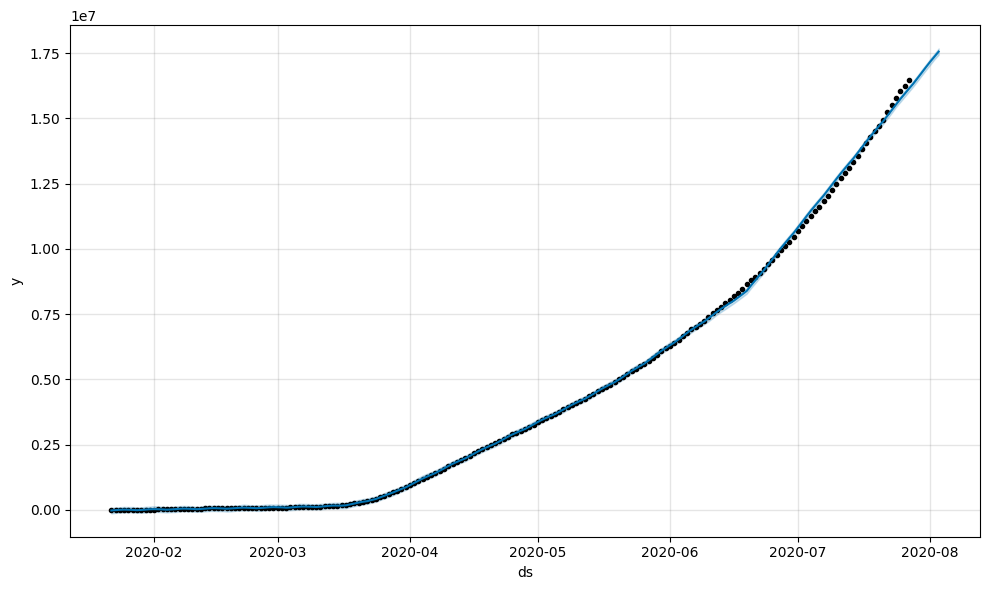

In [12]:
from prophet import Prophet

df_prophet = df_grouped[['Date', 'Confirmed']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

fig = model.plot(forecast)


In [13]:
fig = px.line(forecast, x='ds', y='yhat', title='Predicted COVID-19 Cases for Next 7 Days')
fig.show()


# **Extra visuals**

In [30]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=df_daily['Date'], y=df_daily['Confirmed'],
                         mode='lines+markers', name='Confirmed',
                         line=dict(color='orange')), row=1, col=1)

fig.add_trace(go.Scatter(x=df_daily['Date'], y=df_daily['Recovered'],
                         mode='lines+markers', name='Recovered',
                         line=dict(color='green')), row=1, col=1)

fig.add_trace(go.Scatter(x=df_daily['Date'], y=df_daily['Deaths'],
                         mode='lines+markers', name='Deaths',
                         line=dict(color='red')), row=1, col=1)

fig.update_layout(title='COVID-19 Trend Over Time',
                  xaxis_title='Date',
                  yaxis_title='Number of Cases',
                  template='plotly_white')

fig.show()
last_10 = df_daily.tail(10)

fig2 = go.Figure(data=[
    go.Bar(name='Confirmed', x=last_10['Date'], y=last_10['Confirmed'], marker_color='orange'),
    go.Bar(name='Recovered', x=last_10['Date'], y=last_10['Recovered'], marker_color='green'),
    go.Bar(name='Deaths', x=last_10['Date'], y=last_10['Deaths'], marker_color='red')
])

fig2.update_layout(barmode='group', title='COVID-19 Cases - Last 10 Days',
                   xaxis_title='Date', yaxis_title='Count',
                   template='plotly_white')
fig2.show()


latest = df_daily.iloc[-1]

fig3 = go.Figure(data=[go.Pie(labels=['Confirmed', 'Recovered', 'Deaths'],
                              values=[latest['Confirmed'], latest['Recovered'], latest['Deaths']],
                              hole=0.4)])

fig3.update_layout(title=f'COVID-19 Case Distribution on {latest["Date"].date()}')
fig3.show()
